# Libraries Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage import io, color #Scikit-Image
from PIL import Image # Pillow
import cv2

import os
import random

import torch # Will work on using PyTorch here later
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Create Datasets

In [ ]:
validation_set_size = 0.20            # fraction of dataset used for validation which will be splited randomly

We will initialize the training and validation dataset with the following class

In [ ]:
class HC18(Dataset):
    def __init__(self, train = True, transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(data_folder, 'training_set_pixel_size_and_HC.csv'))
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size = validation_set_size, random_state = 5)

    def __len__(self):
        if self.train:
            return len(self.train_data)
        return len(self.validation_data)
    
    def __getitem__(self, index):
        if self.train:
            imx_name = os.path.join(data_folder, 'training_set', self.train_data.iloc[index, 0])
            imy_name = os.path.join(data_folder, 'training_set', self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))
        else:
            imx_name = os.path.join(data_folder, 'training_set', self.validation_data.iloc[index, 0])
            imy_name = os.path.join(data_folder, 'training_set', self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')
        
        ## tried some data augmentation techniques
        if self.train:
          # Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # Random vertical flipping
          if random.random() > 0.5:
              imx = TF.vflip(imx)
              imy = TF.vflip(imy)

          # Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            imx = TF.rotate(imx, angle)
            imy = TF.rotate(imy, angle)
        
        # We will use resize, tensorlize, and normalize in the following cell
        if self.transformX :
            imx = self.transformX(imx)
            imy = self.transformY(imy)
        
        sample = {'image': imx, 'annotation': imy}
        return sample

Here, we will initialize the transform functions and create our training and validation dataset

In [ ]:
# Init transform functions
tx_X = transforms.Compose([transforms.Resize((572, 572)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))])
tx_Y = transforms.Compose([transforms.Resize((572, 572)),
                           transforms.ToTensor(),  ################ no need to normalize the mask
                           # transforms.Normalize((0.5,), (0.5,))
                          ])
train_data = HC18(train = True, transformX = tx_X, transformY = tx_Y)
validation_data = HC18(train = False, transformX = tx_X, transformY = tx_Y )

In [ ]:
# Dataloaders
train_loader = DataLoader(dataset = train_data, batch_size = 2, shuffle = True, num_workers = 2)
validation_loader = DataLoader(dataset = validation_data, batch_size = 2, shuffle = True, num_workers = 2)

In [ ]:
# The following functions will return numpy array from the transformed tensors which were
# obtained from our train_loader. Plot them and see if they are intact
def im_converterX(tensor):
  image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy 
                                              # as we will need original later
  image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
  # print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image 
                                              # this also outputs (28, 28, 3) which seems important for plt.imshow
  image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
  return image

def im_converterY(tensor):
  image = tensor.cpu().clone().detach().numpy() 
  image = image.transpose(1,2,0) 
  # print(image.shape)
  image = image * np.array((1, 1, 1)) 
  image = image.clip(0, 1) 
  return image

### This is something your will get running the following code
<br>
<div>
<img src="attachment:Screen%20Shot%202022-10-20%20at%203.51.24%20PM.png" width="700" align="left"/>
</div>

0 torch.Size([2, 1, 572, 572]) torch.Size([2, 1, 572, 572])


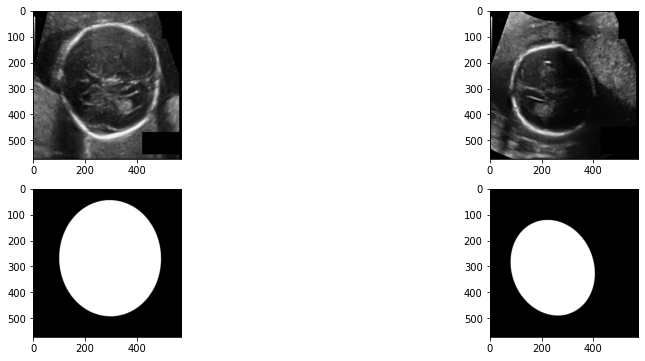

In [ ]:
## Here we loop through our train_loader and see the images
fig = plt.figure(figsize = (15,6))

for ith_batch, sample_batched in enumerate(train_loader):
    print(ith_batch, sample_batched['image'].size(), sample_batched['annotation'].size())
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(sample_batched['image'][index]))
        ax = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(sample_batched['annotation'][index]))
    break

# Save your dataset


In [ ]:
import pickle
with open('train_data.pickle', 'wb') as f:
    pickle.dump(train_data, f)
with open('validation_data.pickle', 'wb') as f:
    pickle.dump(validation_data, f)